In [52]:
import numpy as np
import sys
import math
import scipy.linalg as sl
import matplotlib.pyplot as plt  
%matplotlib notebook
gamma=10
omega_0sq=100

om_max=100
nomega=1000
domega=1

omega=np.linspace(-om_max,om_max,nomega)

omega_arr_symm=np.zeros(2*nomega-1)
conv_kernel=np.zeros((2*nomega-1,2*nomega-1))
conv_kernel_norm_fac=np.zeros((2*nomega-1))

for omega_idx in range(1,nomega):

    omega_arr_symm[nomega+omega_idx-1] =  omega_idx*domega
    omega_arr_symm[nomega-omega_idx-1] = -omega_idx*domega



for omega_0_idx in range(2*nomega-1):
    omega_0= omega_arr_symm[omega_0_idx]
    omega_0sq=omega_0*omega_0

    for omega_idx in range(2*nomega-1):
        omega= omega_arr_symm[omega_idx]
        omegasq=omega*omega

#            if(np.abs(omega_0) > 0.0 or np.abs(omega) > 0.0):
        if(omega_0_idx!=(nomega-1) or omega_idx!=(nomega-1)):
            #print("omega_0={} omega={}".format(omega_0, omega))
            try:
                conv_kernel[omega_0_idx][omega_idx] = 1.*(gamma*omegasq)/(np.pi*((omegasq-omega_0sq)*(omegasq-omega_0sq) + gamma*gamma*omegasq))
            except:
                pass
        else:
#               print("found zero. gamma={}".format(gamma))
#              print(omega_0_idx)
            conv_kernel[omega_0_idx][omega_idx] = 1.0/(np.pi*gamma)
    #        print("theta_conv_kernel[omega_0_idx][omega_idx]= {}".format(theta_conv_kernel[omega_0_idx][omega_idx]))
        conv_kernel_norm_fac[omega_0_idx] += conv_kernel[omega_0_idx][omega_idx]

conv_kernel=np.einsum("ij,i->ij",conv_kernel,1./(conv_kernel_norm_fac*domega))
        
    

    
        


In [53]:
def DeconvoluteSpectrum(omega_arr_symm, theta_symm, theta):

    denom=0.
    DECONV_ITER_CUTOFF=10

    deconv_iter=0
    theta_tilde_outfile=open("theta_tilde.out","w")
    nomegadc=nomega
    fn = np.zeros(2*nomegadc-1)
    fnp1 = np.zeros(2*nomegadc-1)
    h_isra = np.zeros(2*nomegadc-1)
    theta_conv_kernel=np.zeros((2*nomegadc-1,2*nomegadc-1))
    D=np.zeros((2*nomegadc-1,2*nomegadc-1))
    theta_conv_kernel_norm_fac = np.zeros(2*nomegadc-1)
    vv_deconv = np.zeros(2*nomega-1)

        
    for omega_0_idx in range(2*nomegadc-1):
        omega_0= omega_arr_symm[omega_0_idx]
        omega_0sq=omega_0*omega_0
        fn[omega_0_idx]=theta_symm[omega_0_idx] # f0=theta

        for omega_idx in range(2*nomegadc-1):
            omega= omega_arr_symm[omega_idx]
            omegasq=omega*omega
          
#            if(np.abs(omega_0) > 0.0 or np.abs(omega) > 0.0):
            if(omega_0_idx!=(nomegadc-1) or omega_idx!=(nomegadc-1)):
#                print("omega_0={} omega={}".format(omega_0, omega))
                theta_conv_kernel[omega_0_idx][omega_idx] = 1.*(gamma*omegasq)/(np.pi*((omegasq-omega_0sq)*(omegasq-omega_0sq) + gamma*gamma*omegasq))
            else:
 #               print("found zero. gamma={}".format(gamma))
  #              print(omega_0_idx)
                theta_conv_kernel[omega_0_idx][omega_idx] = 1.0/(np.pi*gamma)
        #        print("theta_conv_kernel[omega_0_idx][omega_idx]= {}".format(theta_conv_kernel[omega_0_idx][omega_idx]))

        
            theta_conv_kernel_norm_fac[omega_0_idx] += theta_conv_kernel[omega_0_idx][omega_idx]
            
        #print(theta_conv_kernel_norm_fac[1499])

      
      # for omega_idx in range(2*nomegadc):
      #   omega= omega_arr_symm[omega_idx]        
    theta_conv_kernel=np.einsum("ij,i->ij",theta_conv_kernel,1./(theta_conv_kernel_norm_fac*domega))

    # for omega_0_idx in range(2*nomegadc-1):
    #     for omega_idx in range(2*nomegadc-1):


    #         theta_conv_kernel[omega_0_idx][omega_idx] = theta_conv_kernel[omega_0_idx][omega_idx]/theta_conv_kernel_norm_fac[omega_0_idx]/domega



    h_isra = domega*np.einsum("ij,i->j",theta_conv_kernel,theta_symm)

    # for omega_idx in range(2*nomegadc-1):
    #     for x_idx  in range(2*nomegadc-1):
            
            
    #             try:
    #                 h_isra[omega_idx] += domega*theta_conv_kernel[x_idx][omega_idx]*theta_symm[x_idx]
    #             except:
    #                 print(f"kern={theta_conv_kernel[x_idx][omega_idx]} theta_symm={theta_symm[x_idx]} x_idx={x_idx}")
    #                 exit()

      # set up D(omega,x) = int dy C(y,omega)*C(y,x)

    D=np.einsum("ij,ik->ik",theta_conv_kernel,theta_conv_kernel)
    D*=domega
    print("Set up double convolution kernel")
    # for omega_idx in range(2*nomegadc-1):
    #     for x_idx  in range(2*nomegadc-1):
    #         for y_idx  in range(2*nomegadc-1):
    #             D[omega_idx][x_idx] += domega*theta_conv_kernel[y_idx][omega_idx]*theta_conv_kernel[y_idx][x_idx]

    corr_factor=np.zeros(2*nomegadc-1)

    while(deconv_iter < DECONV_ITER_CUTOFF):
        rel_sq_diff = 0.0
        rel_sq_diff_denom=0.0
        print("iteration {}\n".format(deconv_iter))
#         for omega_idx in range(2*nomegadc-1): #// loop over omega to set f_n+1(omega)=f_n(omega)*h(omega)/int dx D(omega,x) f_n(x)
#             denom=0.
#             for x_idx  in range(2*nomegadc-1):
#                 denom += domega*fn[x_idx]*D[omega_idx][x_idx]

#             fnp1[omega_idx]=fn[omega_idx]*h_isra[omega_idx]/denom
# #        denom = domega*np.einsum("i,ji->",fn,D)
# #fnp1=np.einsum("i,i->i",fn,h_isra/denom)
#         rel_sq_diff_denom=np.einsum("i,i->",fn,fn)
#         rel_sq_diff=np.einsum("i,i->",fnp1-fn,fnp1-fn)/rel_sq_diff_denom
#         print(f"iter = {deconv_iter} rsqd={rel_sq_diff}") 
#         fn=fnp1
        
        for omega_idx in range(2*nomegadc-1): #// loop over omega to set f_n+1(omega)=f_n(omega)*h(omega)/int dx D(omega,x) f_n(x)
            denom=0.

            omega= omega_arr_symm[omega_idx]
            #calculate denominator for each omega
            for x_idx  in range(2*nomegadc-1):
                denom += domega*fn[x_idx]*D[omega_idx][x_idx]
        
            fnp1[omega_idx]=fn[omega_idx]*h_isra[omega_idx]/denom
            rel_sq_diff_denom += fn[omega_idx]*fn[omega_idx]
      

        for omega_idx in range(2*nomegadc-1): 
          rel_sq_diff+= (fnp1[omega_idx] - fn[omega_idx])*(fnp1[omega_idx] - fn[omega_idx])/rel_sq_diff_denom
        print(f"iter = {deconv_iter} rsqd={rel_sq_diff}") 
        
        
        for omega_idx in range(2*nomegadc-1): 
            omega= omega_arr_symm[omega_idx]

            fn[omega_idx] = fnp1[omega_idx]
        
        deconv_iter+=1

      
      # reconvolve theta_tilde to obtain theta

    theta_rec = np.zeros(2*nomegadc-1)
#    theta_rec = domega*np.einsum("ij,j->i",theta_conv_kernel,fn)

    for omega_idx in range(2*nomegadc-1):
    
        if theta_symm[omega_idx] >0.0:
            corr_factor[omega_idx]=(fn[omega_idx]/theta_symm[omega_idx])-1.
        else:
            corr_factor[omega_idx]=0.0
    # try:
    #     corr_factor=(fn/theta_symm)-1.
    #     print(f"corr_factor={corr_factor}")
    # except:
    #     print(f"theta_symm={theta_symm}")

    # for omega_idx in range(2*nomegadc-1):
    #     omega= omega_arr_symm[omega_idx]

    #     if theta_symm[omega_idx] >0.0:
    #         corr_factor[omega_idx]=(fn[omega_idx]/theta_symm[omega_idx])-1.
    #     else:
    #         corr_factor[omega_idx]=0.0

      # reconvolve theta_tilde to obtain theta      
    theta_rec = np.zeros(2*nomegadc-1)
    
    theta_rec=domega*np.einsum("ij,i->j",theta_conv_kernel,fn)
    # for omega_idx in range(2*nomegadc-1):
    #     omega= omega_arr_symm[omega_idx]

    #     if theta_symm[omega_idx] >0.0:
    #         corr_factor[omega_idx]=(fn[omega_idx]/theta_symm[omega_idx])-1.
    #     else:
    #         corr_factor[omega_idx]=0.0
    #     for omegap_idx in range(2*nomegadc-1):
    #       theta_rec[omega_idx] += domega*theta_conv_kernel[omega_idx][omegap_idx]*fn[omegap_idx]



            
    # for omegap_idx in range(2*nomegadc-1):
    #       theta_rec[omega_idx] += domega*theta_conv_kernel[omega_idx][omegap_idx]*fn[omegap_idx]
    for omega_idx in range(nomegadc-1, 2*nomegadc-1):
        vv_deconv[omega_idx-nomegadc] = fn[omega_idx]
        omega= omega_arr_symm[omega_idx]
        theta_tilde_outfile.write("{}\t{}\t{}\t{}\t{}\n".format(omega, theta_symm[omega_idx], vv_deconv[omega_idx-nomegadc],theta_rec[omega_idx],corr_factor[omega_idx]))


    return vv_deconv


(1999, 1999)
(1000,)
Set up double convolution kernel
iteration 0

iter = 0 rsqd=1.1490956035189019e-06
iteration 1

iter = 1 rsqd=1.9314513666677189e-07
iteration 2

iter = 2 rsqd=1.7107547294261363e-07
iteration 3

iter = 3 rsqd=1.3605932915518572e-07
iteration 4

iter = 4 rsqd=1.0679582463832091e-07
iteration 5

iter = 5 rsqd=8.583075324665572e-08
iteration 6

iter = 6 rsqd=7.104027318865307e-08
iteration 7

iter = 7 rsqd=6.064029954827391e-08
iteration 8

iter = 8 rsqd=5.340522059941258e-08
iteration 9

iter = 9 rsqd=4.848380803937968e-08


<IPython.core.display.Javascript object>


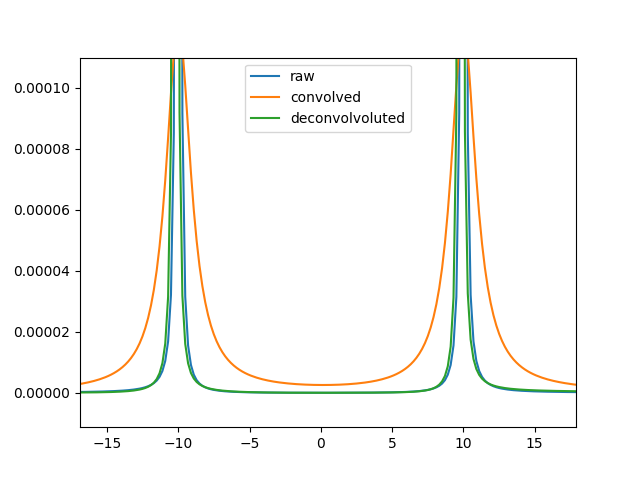

In [54]:
print(np.shape(conv_kernel))
omega=np.linspace(-om_max,om_max,nomega)
omega_0sq=100
gamma0=1e-4
y = 1.*(gamma0*omega**2)/(np.pi*((omega**2-omega_0sq)*(omega**2-omega_0sq) + gamma0*gamma0*omega**2))
print(np.shape(y))

y_arr_symm=np.zeros(2*nomega-1)
y_arr_symm[nomega-1]=y[0]
for omega_idx in range(1,nomega):

    y_arr_symm[nomega+omega_idx-1] = y[omega_idx]
    y_arr_symm[nomega-omega_idx-1] = y[omega_idx]



y_conv=np.einsum("ij,j->i",conv_kernel,y_arr_symm)

y_deconv=DeconvoluteSpectrum(omega_arr_symm, y_arr_symm,y)

plt.plot(omega,y,label="raw")
# plt.plot(omega_arr_symm,y_arr_symm)

plt.plot(omega,y_conv[:nomega],label="convolved")
plt.plot(omega,y_deconv[:nomega],label="deconvolvoluted")

plt.legend()